# Quickstart Example with Synthetic RTB Simulation and Dataset
This notebook provides an example of conducting Off-policy Evaluation (OPE) and Offline Reinforcement Learning (Offline RL) with synthetic Real-Time Bidding (RTB) dataset.

Our example with Synthetic RTB Simualtion and Dataset contains the following 5 steps:
0. (Setup Synthetic RTB Simulation Environment)
1. Synthetic Data Generation
2. Offline Reinforcement Learning
3. Off-Policy Evaluation and Evaluation of Offline RL methods
4. Evaluation of OPE methods

We also show how to visualize the results in Appendix.

In [72]:
# delete later
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [74]:
# delete later
import sys
sys.path.append('../')
sys.path.append('../../')

In [75]:
# import _gym modules
import _gym
from _gym.env import RTBEnv
from _gym.dataset import SyntheticDataset
from _gym.policy import RandomPolicy

In [76]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [77]:
# version
print(_gym.__version__)

0.0.0


## 0. (Setup Synthetic RTB Simulation Environment)
To begin with, we briefly describe how the RTB environment works for the preparation.

#### RL setup for RTB
In RTB, the objective of the RL agent is to maximize some KPIs (such as numbers of click or conversion) within a episode under the given budget constraints.  
We often try to achieve this by adjusting bidding price function parameter :math:`\alpha`. By using :math:`\alpha`, we adjust bid price as follows.  
:math:`bid_{t,i} = \alpha * r*`, 
where :math:`r*` denotes predicted or expected reward (KPIs).

We often formulate this RTB problem as the following Constrained Markov Decision Process (CMDP):
- `timestep`: One episode (a day or a week) consists of several timesteps (24 hours or seven days, for instance).
- `state`: We observe statistical feedback from environment at each timestep, which include following informations.
  - timestep
  - remaining budget
  - impression level features (budget comsuption rate, cost per mille of impressions, auction winning rate, reward) at previous timestep
  - adjust rate (RL agent's decision making) at previous timestep
- `action`: Agent chooses adjust rate parameter :math:`\alpha` to maximize KPIs.
- `reward`: Total number of clicks or conversions obtained during the timestep.
- `constraints`: The pre-determined episodic budget should not be exceeded.

Let's see how it works!

In [78]:
# reward predictor used to determine bid price
from sklearn.linear_model import LogisticRegression

In [775]:
# setup environment
env = RTBEnv(reward_predictor=LogisticRegression())  # when set to None, the ground-truth (expected) reward is used instead of the predicted reward
# fit reward predictor in advance
env.fit_reward_predictor()

In [776]:
# define agent
agent = RandomPolicy(env)

In [777]:
# interact agent with environment
# only 6 lines needed for RL interaction
for episode in range(10):
    obs = env.reset()
    done = False

    while not done:
        action, _ = agent.act(obs)
        obs, reward, done, info = env.step(action)

In [778]:
# state contains the following statistical feedback from environment
print(env.obs_keys)
print(obs.shape)

['timestep', 'remaining budget', 'budget consumption rate', 'cost per mille of impression', 'winning rate', 'reward', 'adjust rate']
(7,)


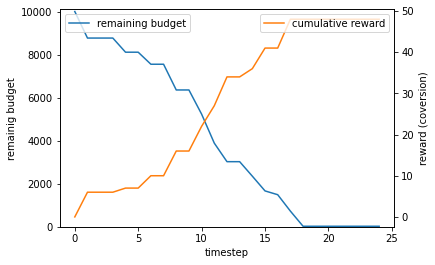

In [784]:
# let's visualize the transition of remaing budget and cumulative reward
# our goal is to gain a policy (i.e., agent) which maximize the cumulative reward under budget constraints using RL.  
# for more visulization, please see appendix.
obs = env.reset()
done = False
remaining_budget = [obs[1]]
cumulative_reward = [0]

while not done:
    action, _ = agent.act(obs)
    obs, reward, done, info = env.step(action)
    remaining_budget.append(obs[1])
    cumulative_reward.append(cumulative_reward[-1] + reward)

# plot
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(remaining_budget, label='remaining budget')
ax2 = ax1.twinx()
ax2.plot(cumulative_reward, label='cumulative reward', color='tab:orange')
ax1.set_xlabel('timestep')
ax1.set_ylabel('remainig budget')
ax1.set_ylim(0, env.initial_budget + 100)
ax2.set_ylabel('reward (coversion)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

For the customization of the environment, we have following arguments:
- `semi_synthetic`: Whether to use semi-synthetic environment. Currently only False option is supported (will be implemented).
- `objective`: Objective KPIs of RTB, which is either "click" or "conversion".
- `action_type`: Action type of the RL agent, which is either "discrete" or "continuous".
- `action_dim`: Dimention of "discrete" action.
- `action_maening`: Mapping function of agent action index to the actual "discrete" action to take.
- `reward_predictor`: A machine learning model to predict the reward to determine the bidding price.
- `step_per_episode`: Number of timesteps in an episode.
- `initial_budget`: Initial budget (i.e., constraint) for bidding during an episode.
- `n_ads`: Number of ads used for auction bidding.
- `n_users`: Number of users used for auction bidding.
- `ad_feature_dim`: Dimensions of the ad feature vectors.
- `user_feature_dim`: Dimensions of the user feature vectors.
- `standard_bid_price_distribution`: Distribution of the bid price whose average impression probability is expected to be 0.5.
- `minimum_standard_bid_price`: Minimum value for standard bid price.
- `trend_interval`: Length of the CTR/CVR trend cycle, where we define CTR as click per impression and CVR as conversion per click.
- `ad_sampling_rate`: Sampling probalities to determine which ad (id) is used in each auction.
- `user_sampling_rate`: Sampling probalities to determine which user (id) is used in each auction.
- `search_volume_distribution`: Search volume distribution for each timestep.
- `minimum_search_volume`: Minimum search volume at each timestep.
- `random_state`: Random state.

Please also see `_gym/env/rtb.py` for details.

## 1. Synthetic Dataset Generation
In the previous section, we see how we can interact the environment *online* using synthetic simulator.  
Though simulation is a good start for training agent, eventually we want to train and evaluate our agent (or policy) in the real world environment for deployment.  
However, online interaction may have potential risk of failure in real-world implementataion.  
Therefore, we introduce alternative learning protocol, Offline RL, which aim to obtain a new policy using only offline logged dataset.

We prepare easy-to-use synthetic dataset generator: `SyntheticDataset` class in the dataset module.  
By regarding simulation environment as a hypothetical real-environment, we show how to conduct Offline RL using logged dataset in real-world application.  
For detailed description of how to use real-world dataset, please see #TODO (will be implemented).

We have following arguments for `SyntheticDataset` class:
- `env`: RTB environment for RL defined in the previous section.
- `bahavior_policy`: RL agent (or algorithm) used for the data collection.
- `n_samples_pretrain_reward_predictor`: Numbers of samples used to pretrain reward predictor.

In [785]:
# initialize dataset class
dataset = SyntheticDataset(
    env=env,
    behavior_policy=agent,
)

In [786]:
# pretrain behavior policy (unnecessary when using RandomPolicy)
dataset.pretrain_behavior_policy(n_episodes=100)

[pretrain_behavior_policy]: 100%|██████████| 100/100 [00:02<00:00, 49.45it/s]


In [787]:
# collect logged data using behavior policy
logged_dataset = dataset.obtain_trajectories(n_episodes=100)

[obtain_trajectories]: 100%|██████████| 100/100 [00:01<00:00, 50.69it/s]


In [788]:
logged_dataset

{'size': 2400,
 'n_episodes': 100,
 'step_per_episode': 24,
 'action_type': 'discrete',
 'action_dim': 10,
 'action_meaning': array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
         1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ]),
 'state_keys': ['timestep',
  'remaining budget',
  'budget consumption rate',
  'cost per mille of impression',
  'winning rate',
  'reward',
  'adjust rate'],
 'state': array([[0.00000000e+00, 1.00000000e+04, 8.16144729e-01, ...,
         2.73444174e-02, 1.00000000e+00, 9.00000000e+00],
        [1.00000000e+00, 9.79000000e+03, 2.10000000e-02, ...,
         3.64077670e-01, 1.00000000e+00, 7.74263683e-01],
        [2.00000000e+00, 9.79000000e+03, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.00000000e-01],
        ...,
        [2.10000000e+01, 3.63000000e+02, 7.05596107e-01, ...,
         1.00000000e+00, 4.00000000e+00, 1.00000000e+01],
        [2.20000000e+01, 3.63000000e+02, 0.00000000e+00, ...,
  

In [789]:
# on-policy policy value of behavior policy
dataset.calc_on_policy_policy_value(n_episodes=100)

[calc_on_policy_policy_value]: 100%|██████████| 100/100 [00:02<00:00, 41.23it/s]


49.44

In [790]:
# check statistics of the dataset
df = pd.DataFrame()
df['adjust rate'] = logged_dataset['state'][:, 6]
df['average bid price'] = logged_dataset['info']['average bid price']
df['impression'] = logged_dataset['info']['impression']
df['click'] = logged_dataset['info']['click']
df['conversion'] = logged_dataset['info']['conversion']
df['winning rate'] = logged_dataset['state'][:, 4]
df['click / impression'] = df['click'] / (df['impression'] + 1e-5)
df['conversion / click'] = df['conversion'] / (df['click'] + 1e-5)
df.describe()

,adjust rate,average bid price,impression,click,conversion,winning rate,click / impression,conversion / click
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,2.503841,122.836810,84.102083,8.414583,2.022083,0.436847,0.059557,0.132253
std,3.054978,154.418629,90.314041,9.721218,2.649123,0.446289,0.068553,0.172338
min,0.000000,4.127962,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.278256,13.629868,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,41.307476,43.000000,2.000000,0.000000,0.266157,0.063492,0.000000
75%,3.593814,180.415757,184.000000,17.000000,4.000000,0.990099,0.103235,0.249999
max,10.000000,558.767196,264.000000,42.000000,15.000000,1.000000,0.499999,0.999998


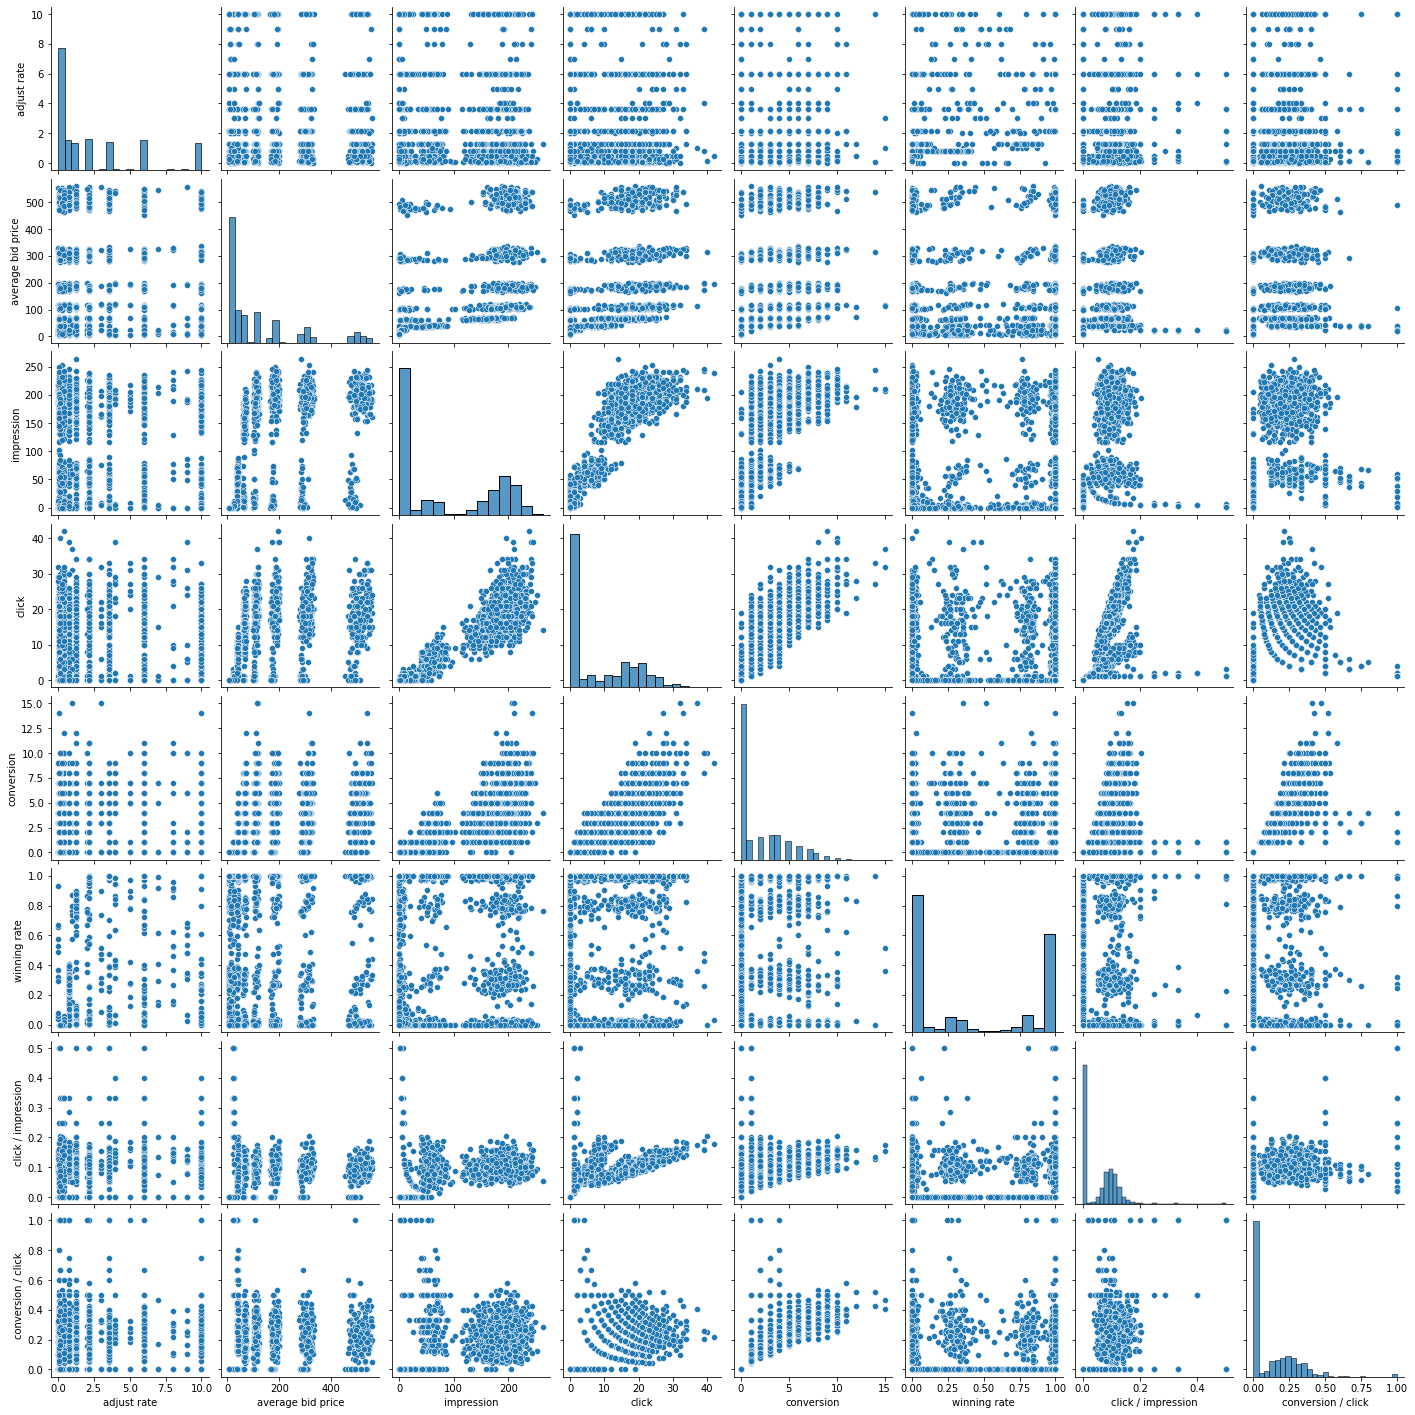

In [791]:
sns.pairplot(df)

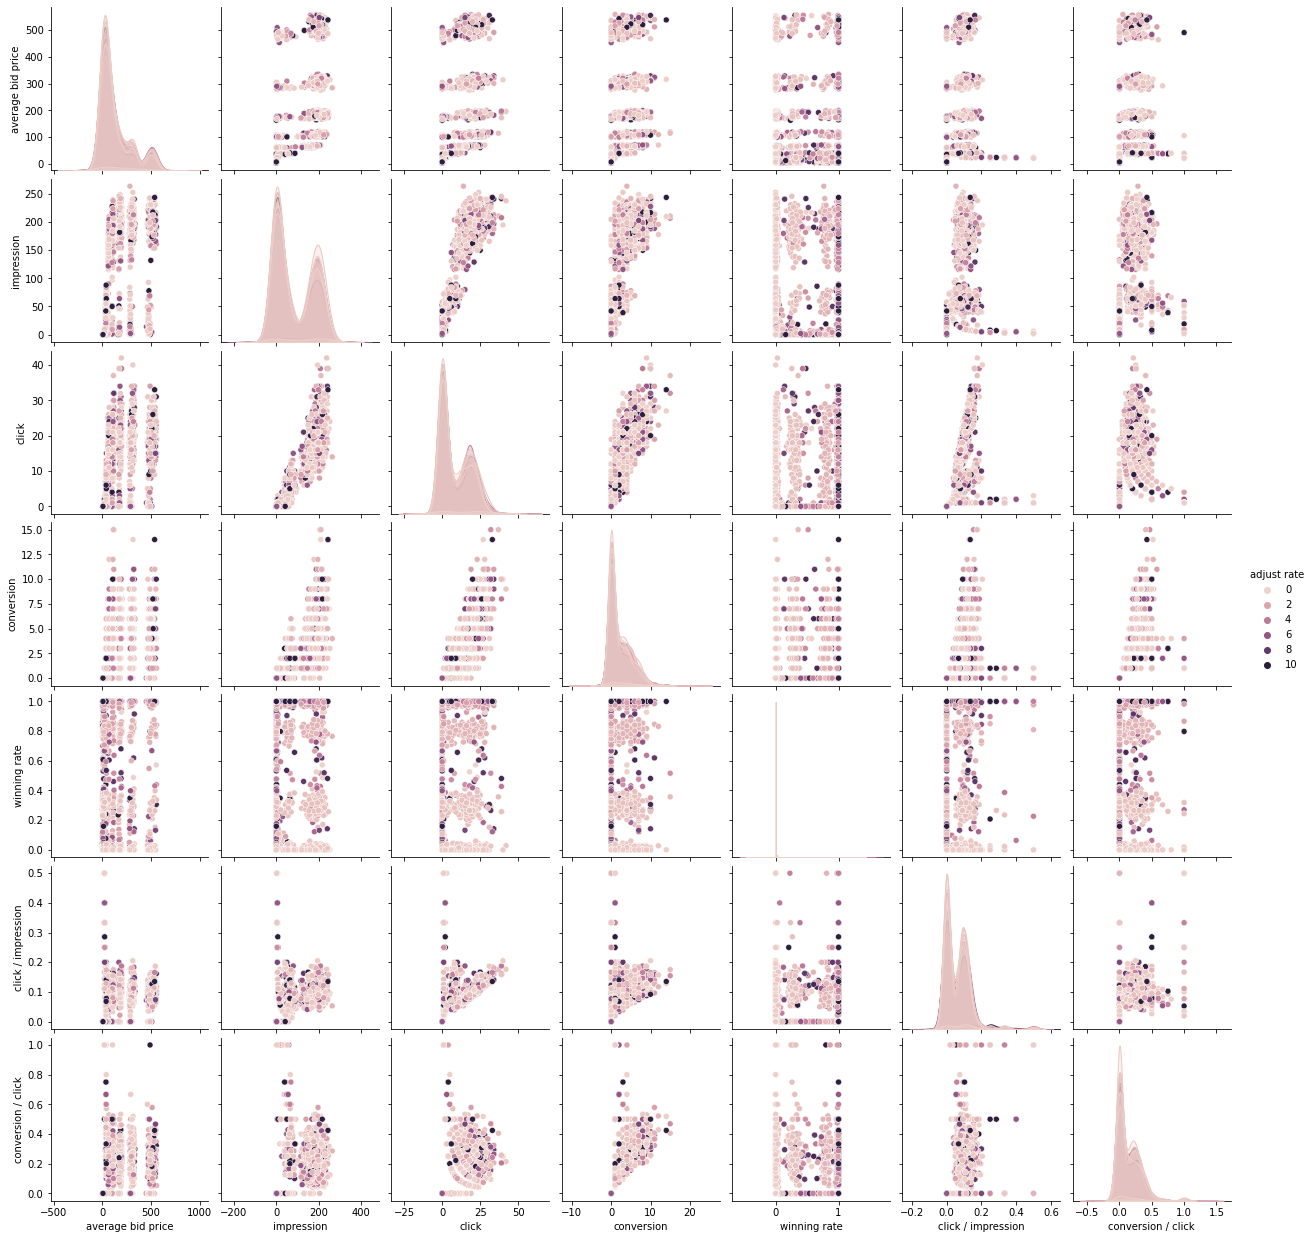

In [792]:
# we see that large adjust rate does not always lead to high reward (conversion) because of the budget constraints
# therefore, it is important to appropriately controling adjust rate parameter by RL policy (agent)
# please see more visualization in appendix
sns.pairplot(df, hue='adjust rate')

## 2. Offline Reinforcement Learning

## 3. Off-Policy Evaluation and Evaluation of Offline RL methods

## 4. Evaluation of OPE methods

## Appendix
Here we provide useful visualization function and insights of Synthetic RTB Simulation environment.

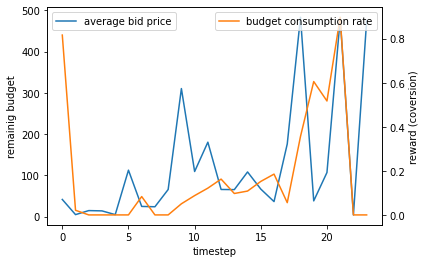

In [793]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(np.arange(24), df['average bid price'][:24], label='average bid price')

ax2 = ax1.twinx()
ax2.plot(np.arange(24), logged_dataset['state'][:,2][:24], label='budget consumption rate', color='tab:orange')

ax1.set_xlabel('timestep')
ax1.set_ylabel('remainig budget')
ax2.set_ylabel('reward (coversion)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

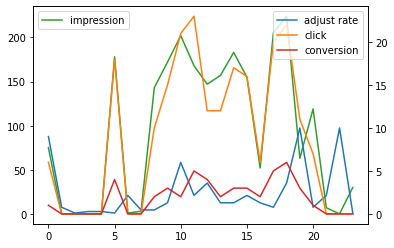

In [794]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(np.arange(24), df['impression'][:24], color='tab:green', label='impression')
ax2 = ax1.twinx()
ax2.plot(np.arange(24), df['adjust rate'][:24], label='adjust rate')
ax2.plot(np.arange(24), df['click'][:24], label='click')
ax2.plot(np.arange(24), df['conversion'][:24], 'tab:red', label='conversion')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

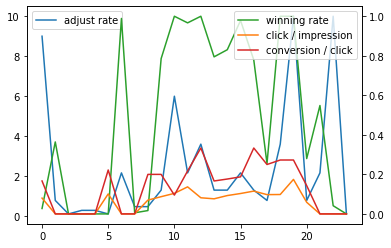

In [795]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(np.arange(24), df['adjust rate'][:24], label='adjust rate')
ax2 = ax1.twinx()
ax2.plot(np.arange(24), df['winning rate'][:24], color='tab:green', label='winning rate')
ax2.plot(np.arange(24), df['click / impression'][:24], color='tab:orange', label='click / impression')
ax2.plot(np.arange(24), df['conversion / click'][:24], color='tab:red', label='conversion / click')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

In [796]:
df_ = pd.DataFrame()
df_['average adjust rate'] = logged_dataset['state'][:, 6].reshape(-1, 24).mean(axis=1)
df_['average bid price'] = logged_dataset['info']['average bid price'].reshape(-1, 24).mean(axis=1)
df_['total impression'] = logged_dataset['info']['impression'].reshape(-1, 24).mean(axis=1)
df_['total click'] = logged_dataset['info']['click'].reshape(-1, 24).mean(axis=1)
df_['total conversion'] = logged_dataset['info']['conversion'].reshape(-1, 24).mean(axis=1)
df_['ramainind budget'] = logged_dataset['state'][:,1].reshape(-1, 24)[:,23]

In [797]:
df_.describe()

,average adjust rate,average bid price,total impression,total click,total conversion,ramainind budget
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.503841,122.836810,84.102083,8.414583,2.022083,520.670000
std,0.592727,30.480877,9.246136,0.717383,0.302235,932.336351
min,1.070971,51.739589,46.625000,5.416667,1.250000,2.000000
25%,2.075023,101.713343,79.500000,8.364583,1.791667,12.000000
50%,2.545658,123.901564,84.979167,8.625000,2.000000,28.000000
75%,2.869027,141.689322,89.833333,8.833333,2.250000,676.000000
max,4.459101,233.003924,105.666667,9.333333,2.958333,4818.000000


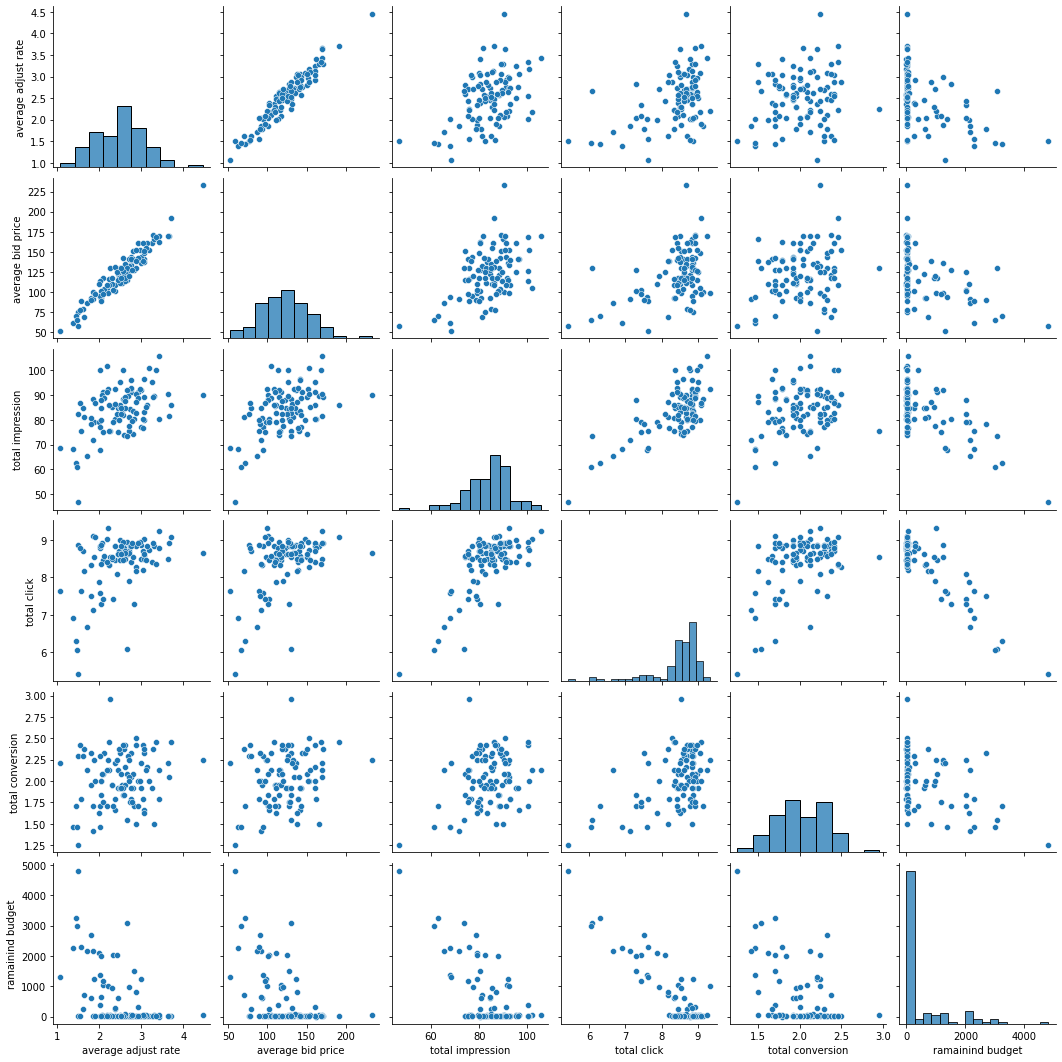

In [798]:
sns.pairplot(df_)

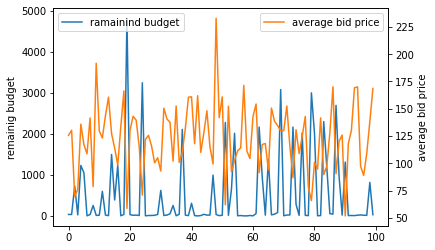

In [799]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(np.arange(100), df_['ramainind budget'], label='ramainind budget')
ax2 = ax1.twinx()
ax2.plot(np.arange(100), df_['average bid price'], label='average bid price', color='tab:orange')
ax1.set_ylabel('remainig budget')
ax2.set_ylabel('average bid price')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

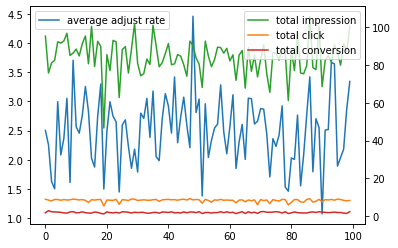

In [800]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(np.arange(100), df_['average adjust rate'], label='average adjust rate')
ax2 = ax1.twinx()
ax2.plot(np.arange(100), df_['total impression'], label='total impression', color='tab:green')
ax2.plot(np.arange(100), df_['total click'], label='total click', color='tab:orange')
ax2.plot(np.arange(100), df_['total conversion'], label='total conversion', color='tab:red')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()